In this notebook, we visualize the 1D coding scheme for approximating functions from $L^p([0,1],[0,1])$ in $L^p$ norm with activations corresponding to LReLUs and G-ReLUs given by the sets $\mathcal{F}_{+}$ and $\mathcal{F}_{\pm}$ from the paper, respectively. Note that these are the larger LReLU sets in which we directly build our LReLU constructions. For the single-parameter sets, we would further need to approximate the LReLUs from this construction with width-one LReLU networks, resulting in super-exponential depth. Therefore, we omit doing this here and only work with the construction using the large LReLU sets; otherwise, runtime will explode even for very small parameters, making the code and visualizations tediously slow.

Further, one should note that even in this case, we would normally not approximate $f\in L^p([0,1],[0,1])$ directly, but instead a continuous function that approximates it well. However, for simpler non-continuous functions $f$, the coding scheme implicitly works in this case, as it is constructed as a continuous function that fits actual function values of $f$ on sets which are part of a partition of $[0,1]$, where each set of the partition can have arbitrarily small volume. As long as $f$ is piecewise continuous, we can therefore directly apply the coding scheme without needing to find a continuous approximator of it first. Note that this may fail for more complex Lebesgue-integrable functions, e.g., if $f$ has single-point discontinuities; however, for this reason we exclude such examples for simplicity.

In [1]:
import torch
import matplotlib.pyplot as plt
from coding_scheme_base_functions import (Sigma_ab_cd, EncoderApprox1D, ZigZagMemorizer, CodingScheme1D, EncoderSupApprox1D, PLCSMMemorizer)

In [2]:
# set the device and dtype (torch.float64 is recommended for precision) of your choice
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float64

The following code creates our shifted and rescaled LReLU variants, given by $\sigma_{a,b}^{c,d}$. As these are very important for all of our constructions, we plot each type to show that we can construct them as needed. Note that these are built from scratch using pure width-one LReLU FNNs.

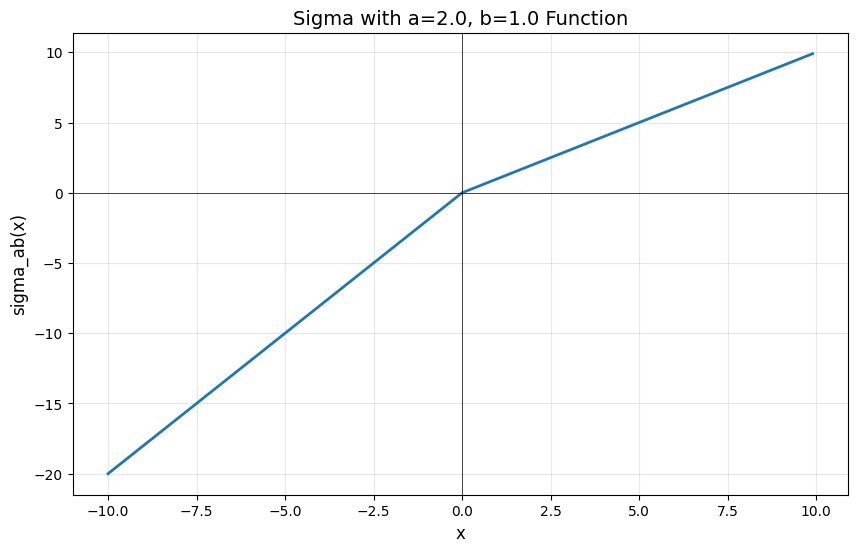

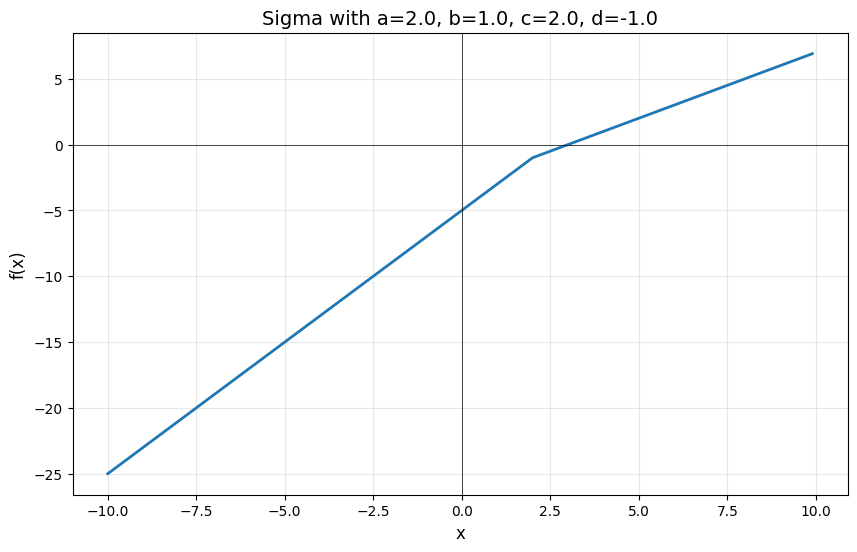

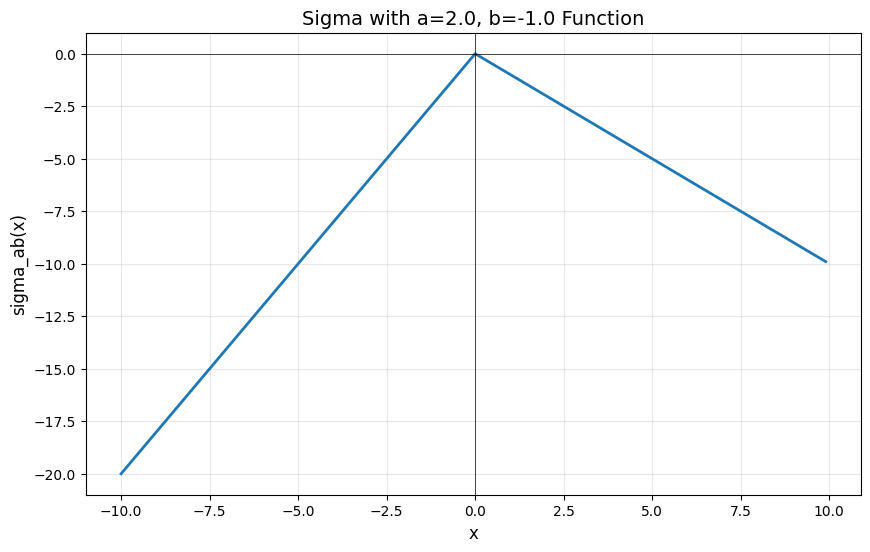

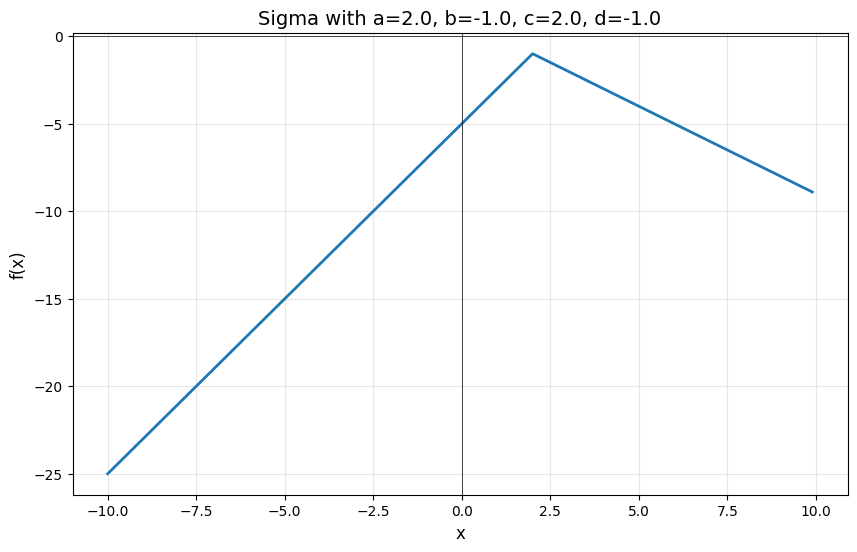

In [3]:
c, d = 2, -1

# Example 1: a>0, b>0 (both positive slopes)
a, b = 2, 1
sigma = Sigma_ab_cd(a, b, c, d, dtype=dtype, device=device)
points = torch.arange(-10, 10, 0.1)
sigma.plot_sigma_ab(points)
sigma.plot_sigma(points)

# Example 2: a>0, b<0 (positive and negative slopes)
a, b = 2, -1
sigma = Sigma_ab_cd(a, b, c, d, dtype=dtype, device=device)
points = torch.arange(-10, 10, 0.1)
sigma.plot_sigma_ab(points)
sigma.plot_sigma(points)

Now that we've verified that our $\sigma_{a,b}^{c,d}$ functions work as expected, we can test out the functionality of the encoder approximation, which is again built as a composition of leaky ReLUs. Note that the number of composed leaky ReLUs scales exponentially with the discretization constant $K$, and that the construction's precision might suffer if flat_slope and $\gamma$ get very small. However, the construction will only converge if flat_slope and $\gamma$ are lowered to (almost) zero and $K$ can be arbitrarily large. These circumstances already imply that this construction won't be able to achieve arbitrarily precise approximations of the encoder due to exponential runtime growth with large $K$, and because either very small or large slopes corresponding to flat_slope and $\gamma$ will lead to underflows or overflows at some point. To hopefully achieve the construction in a relatively precise manner for parameters of decent magnitudes, we use torch.float64 by default.

## Part 1: Encoder Approximation

Note that in the 1D case, the encoder corresponds directly to the quantizer, so these two components are equivalent. Furthermore, the decoder in 1D is simply the identity function, which is why we do not need to construct it separately.

**Parameter Control for Convergence:**
- **$\gamma \to 0$** and **flat_slope $\to 0$**: These parameters control how closely the encoder approximation matches the true encoder. As they approach zero, the approximation becomes more accurate.
- **Warning**: Very small values (below $10^{-6}$) may lead to numerical instabilities due to extreme slopes.

Now we plot our encoder approximations for different parameters of $K$, $\gamma$, and flat_slope. Note that there always must be a subset of $[0,1]$ on which we cannot decrease the supremum norm error to zero if $K$ stays constant, independent of how we choose the parameters of our encoder approximation, as in this case we don't use discontinuous activations but only LReLUs. However, we see that choosing $\gamma$ closer to zero results in our approximation transferring between the lower and upper encoder values faster and in a smaller interval, i.e., the volume of the set with large supremum norm errors with respect to the Lebesgue measure decreases. Moreover, decreasing the flat_slope leads to smaller errors everywhere outside of that set. Thus overall, we can approximate the encoder arbitrarily well with respect to the supremum norm outside of a subset that we can make arbitrarily small, which is exactly what will suffice for $L^p$ approximation.

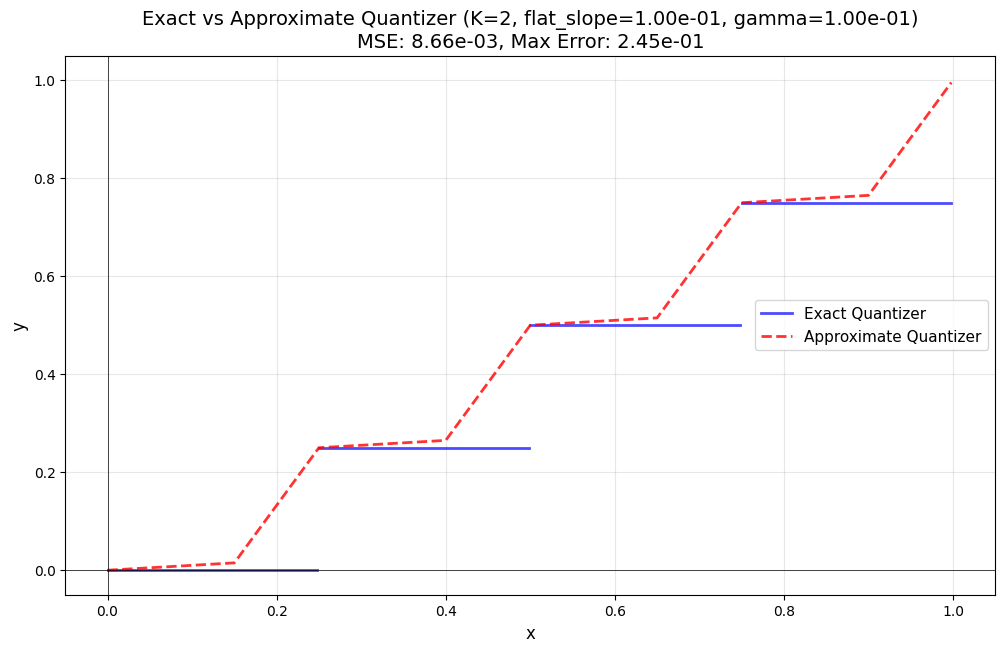

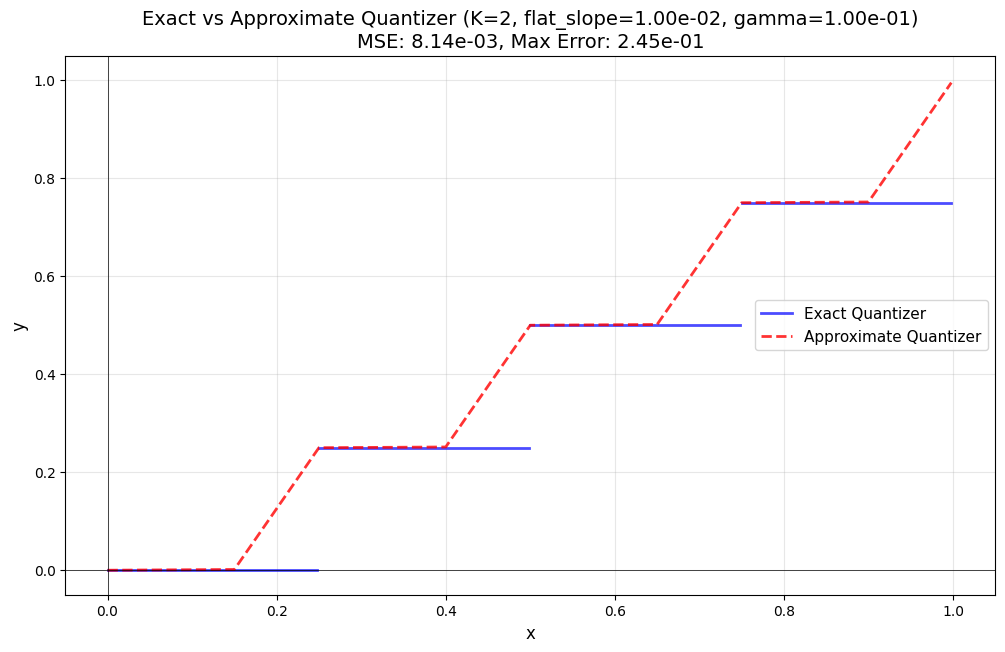

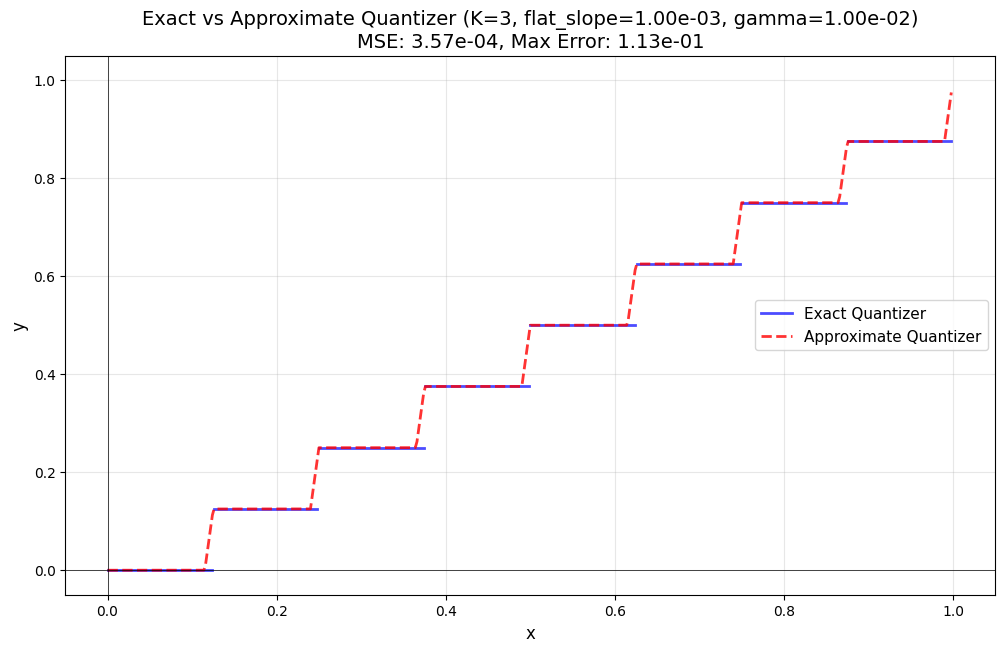

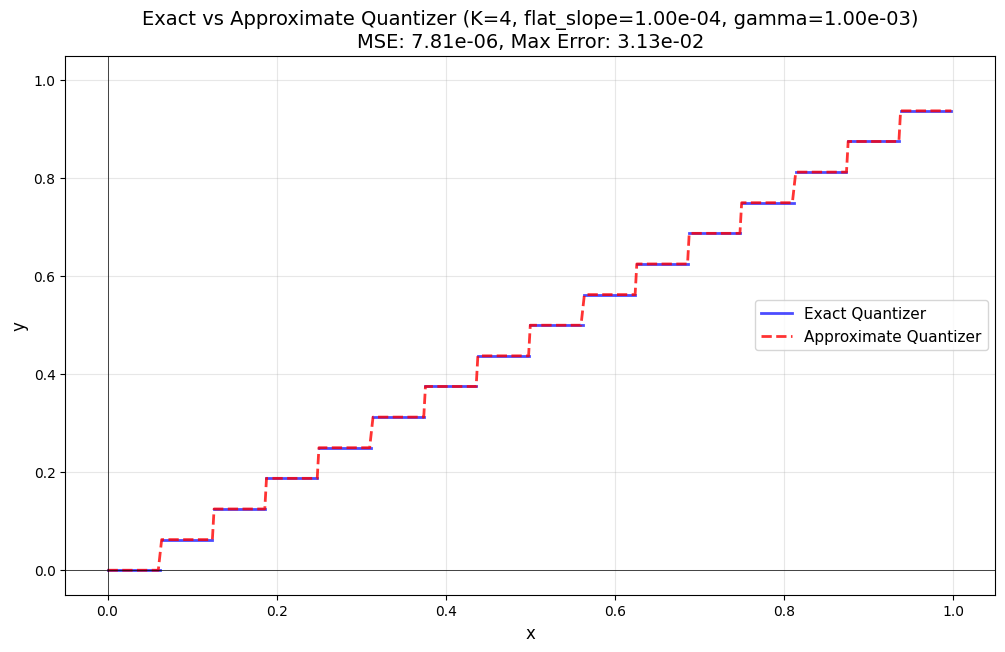

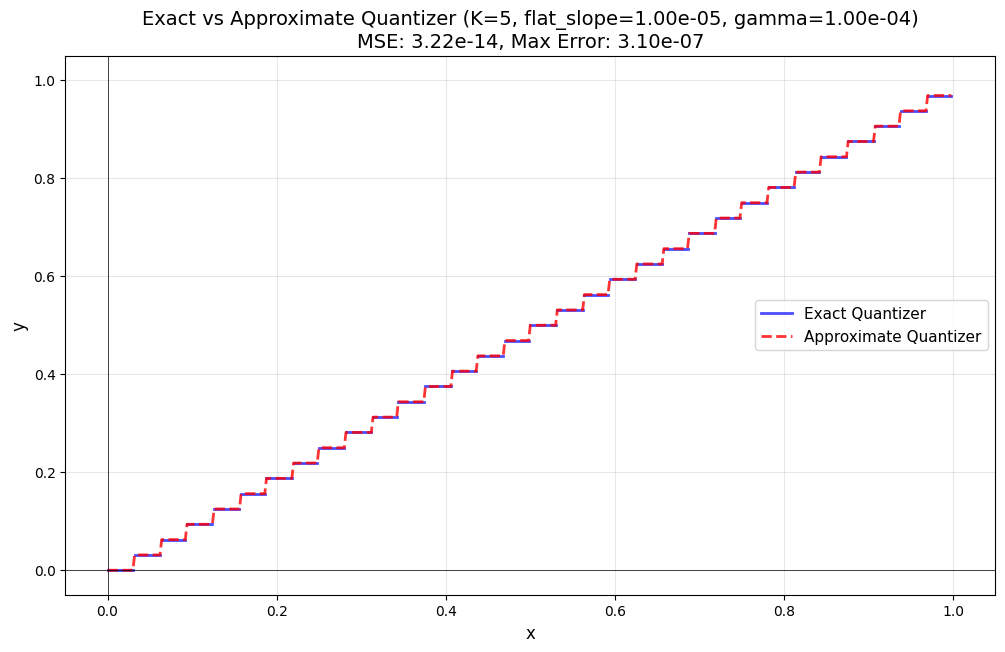

(3.216280491936156e-14, 3.0999999989234084e-07)

In [ ]:
# create encoders with increasingly large K and decaying float_slope and gamma and plot them on the interval of interest [0,1]
encoder1 = EncoderApprox1D(K=2, gamma=0.1, flat_slope=1e-1, dtype=dtype, device=device)
encoder2 = EncoderApprox1D(K=2, gamma=0.1, flat_slope=1e-2, dtype=dtype, device=device)
encoder3 = EncoderApprox1D(K=3, gamma=0.01, flat_slope=1e-3, dtype=dtype, device=device)
encoder4 = EncoderApprox1D(K=4, gamma=0.001, flat_slope=1e-4, dtype=dtype, device=device)
encoder5 = EncoderApprox1D(K=5, gamma=0.0001, flat_slope=1e-5, dtype=dtype, device=device)

# plot encoders (capturing return values to suppress printed tuples)
points = torch.arange(0, 1, 0.002, dtype=dtype, device=device)
_ = encoder1.plot_with_exact(points)
_ = encoder2.plot_with_exact(points)
_ = encoder3.plot_with_exact(points)
_ = encoder4.plot_with_exact(points)
_ = encoder5.plot_with_exact(points)

# if needed, uncomment the lines below to plot only the approximate encoder without the exact one, 
# encoder1.plot(points)
# encoder2.plot(points)
# encoder3.plot(points)
# encoder4.plot(points)
# encoder5.plot(points)

As we've now seen that the construction of the encoder works accordingly, we can take a look at the zig-zag functions that are supposed to fit a given function f exactly on finitely many given points. For this and the overall approximation we define several functions to be exactly fitted by the zig-zag function and the entire coding scheme. We select them in such a way that they contain both non-monotonic and discontinuous functions. It should be noted that it is impossible to approximate a non-monotonic function using a composition of monotonic functions, since the result will always be monotonic. Furthermore, the most popular choices tend to be monotonic activations.

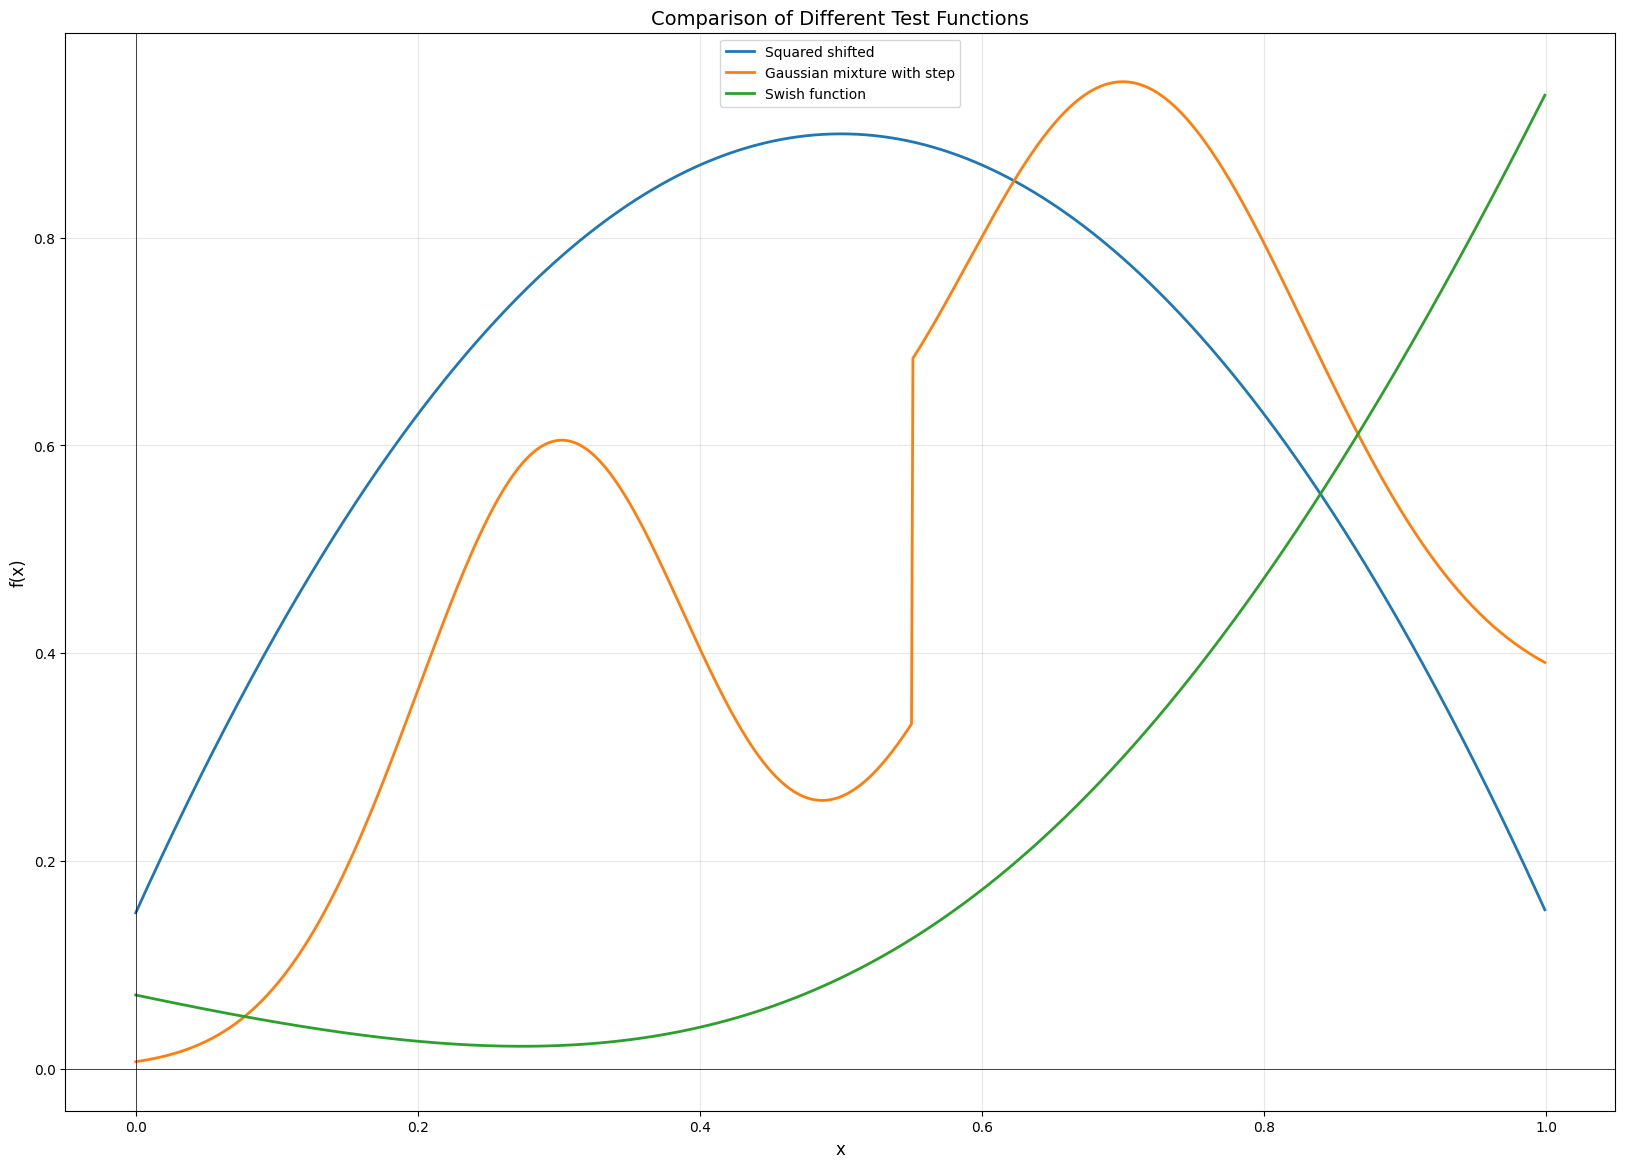

In [ ]:
# Define test functions for approximation
def squared_shifted(x):
    return -3 * (x - 0.5) ** 2 + 0.9

def smooth_gaussian_mixture(x):
    # Continuous multi-peak Gaussian mixture
    return 0.5 * torch.exp(-80 * (x - 0.25) ** 2) + 0.7 * torch.exp(-60 * (x - 0.6) ** 2) + 0.4 * torch.exp(-100 * (x - 0.85) ** 2) + 0.1

def swish_shifted(x):
    return 3 * (x - 0.7) * torch.sigmoid(3 * (x - 0.7)) + 0.3

# SELECT BASE FUNCTION HERE - Change this to use a different function throughout the notebook
base_function = squared_shifted
base_function_name = "Squared Shifted Function"

# Alternative options (uncomment to use):
# base_function = smooth_gaussian_mixture
# base_function_name = "Smooth Gaussian Mixture Function"

# base_function = swish_shifted
# base_function_name = "Swish Shifted Function"

# Optional: Plot comparison of functions (comment out if not needed)
def plot_test_functions(function_list):
    """
    Plot multiple test functions for comparison.
    
    Args:
        function_list: List of tuples (function, name) to plot
    """
    points = torch.arange(0, 1, 0.001, dtype=dtype, device=device)
    plt.figure(figsize=(20, 14))
    for func, name in function_list:
        plt.plot(points.cpu().numpy(), func(points).cpu().numpy(), label=name, linewidth=2)
    plt.grid(True, alpha=0.3)
    plt.xlabel('x', fontsize=12)
    plt.ylabel('f(x)', fontsize=12)
    plt.title('Comparison of Different Test Functions', fontsize=14)
    plt.axhline(y=0, color='k', linewidth=0.5)
    plt.axvline(x=0, color='k', linewidth=0.5)
    plt.legend()
    plt.show()

# Comparison plot of all test functions
# Add your own functions to the list if desired: [(your_function, "Your Function Name"), ...]
plot_test_functions([
    (squared_shifted, "Squared shifted"),
    (smooth_gaussian_mixture, "Smooth Gaussian mixture"),
    (swish_shifted, "Swish shifted")
])

## Part 2: Coding Scheme with Zig-Zag Memorizer

Now we demonstrate the zig-zag memorizer construction using the selected base function. The zig-zag memorizer fits the function exactly on finitely many points.

Recall that in 1D, the complete coding scheme is given by the encoder (quantizer) composed with the memorizer, since the decoder is simply the identity function.

**🔑 Key Insight - Network Width:**
- **Zig-Zag Memorizer = Width-1 FNN**: The zig-zag memorizer is constructed as a purely width-one feedforward neural network (FNN)
- **Coding Scheme with Zig-Zag = Width-1**: Since encoder and decoder are also width-1, the complete coding scheme remains width-1
- **Built from scratch**: All constructions use only our $\sigma_{a,b}^{c,d}$ functions, which are simple width-1 compositions of LReLUs - nothing else!

This demonstrates that universal approximation is achievable with **minimal width** (width-1) networks using only basic LReLU compositions.

**Parameter Control for Coding Scheme Accuracy:**
- **$K \to \infty$** and **$M \to \infty$**: These parameters control how well the coding scheme fits the base function. Larger values result in better approximation of the target function, as the memorizer can fit more points with higher precision.
- Combined with the encoder parameters ($\gamma \to 0$, flat_slope $\to 0$), the complete coding scheme converges to the true coding scheme construction.
- **⚠️ Warning**: Large $K$ values lead to **exponential runtime increase** (number of function compositions grows as $2^K$). Values $K > 10$ may result in significant slowdown. Additionally, large $K$ and $M$ values can cause numerical instabilities due to the complexity of the composed functions.

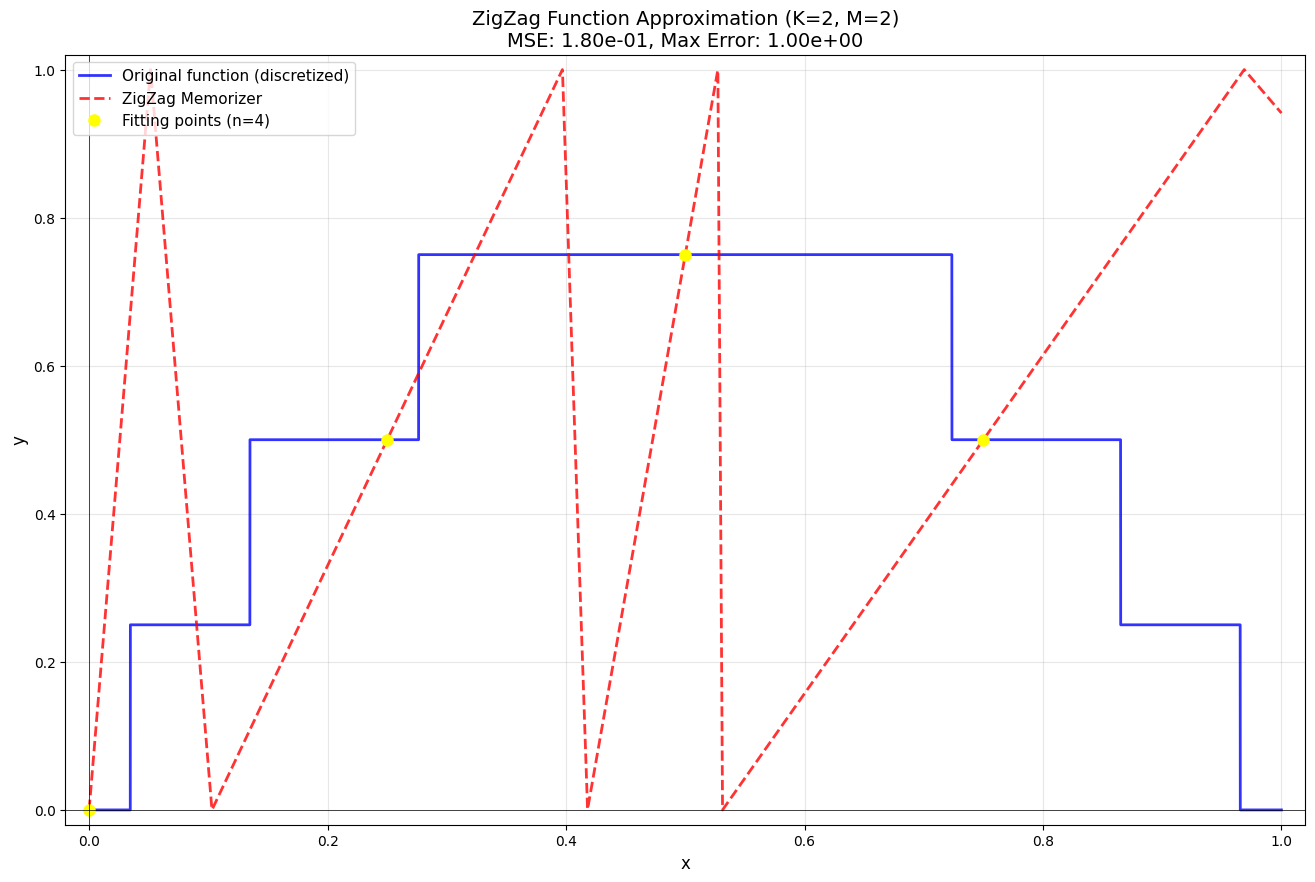

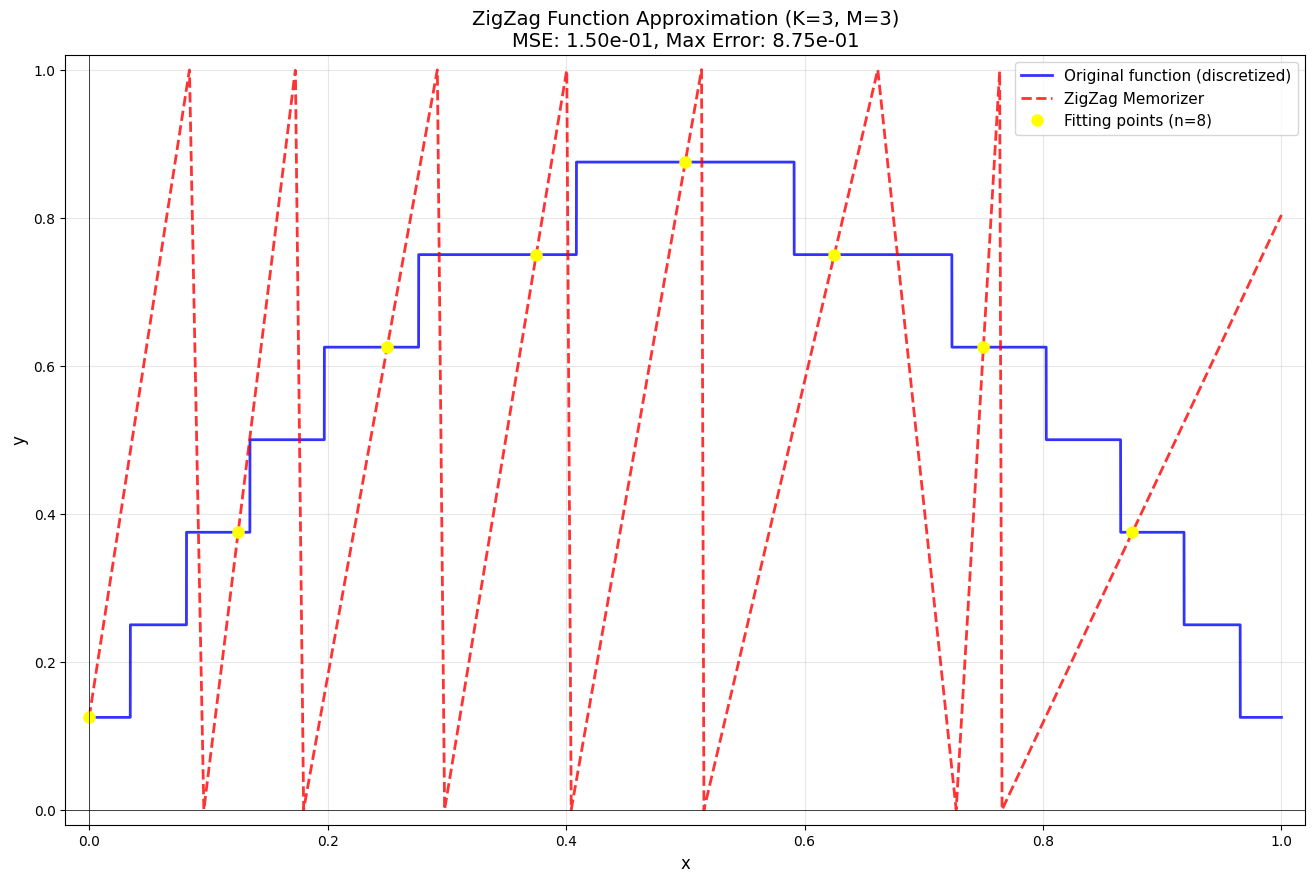

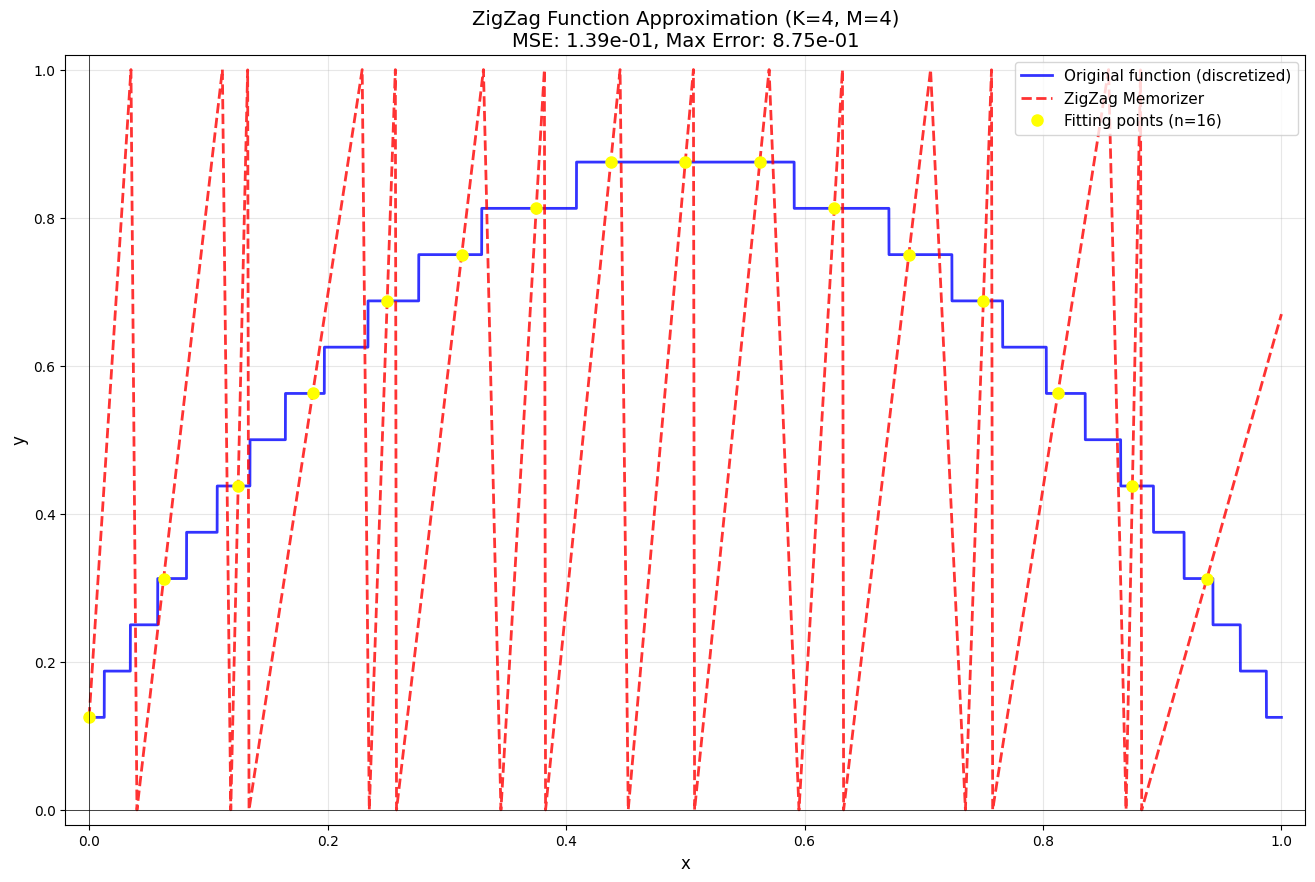

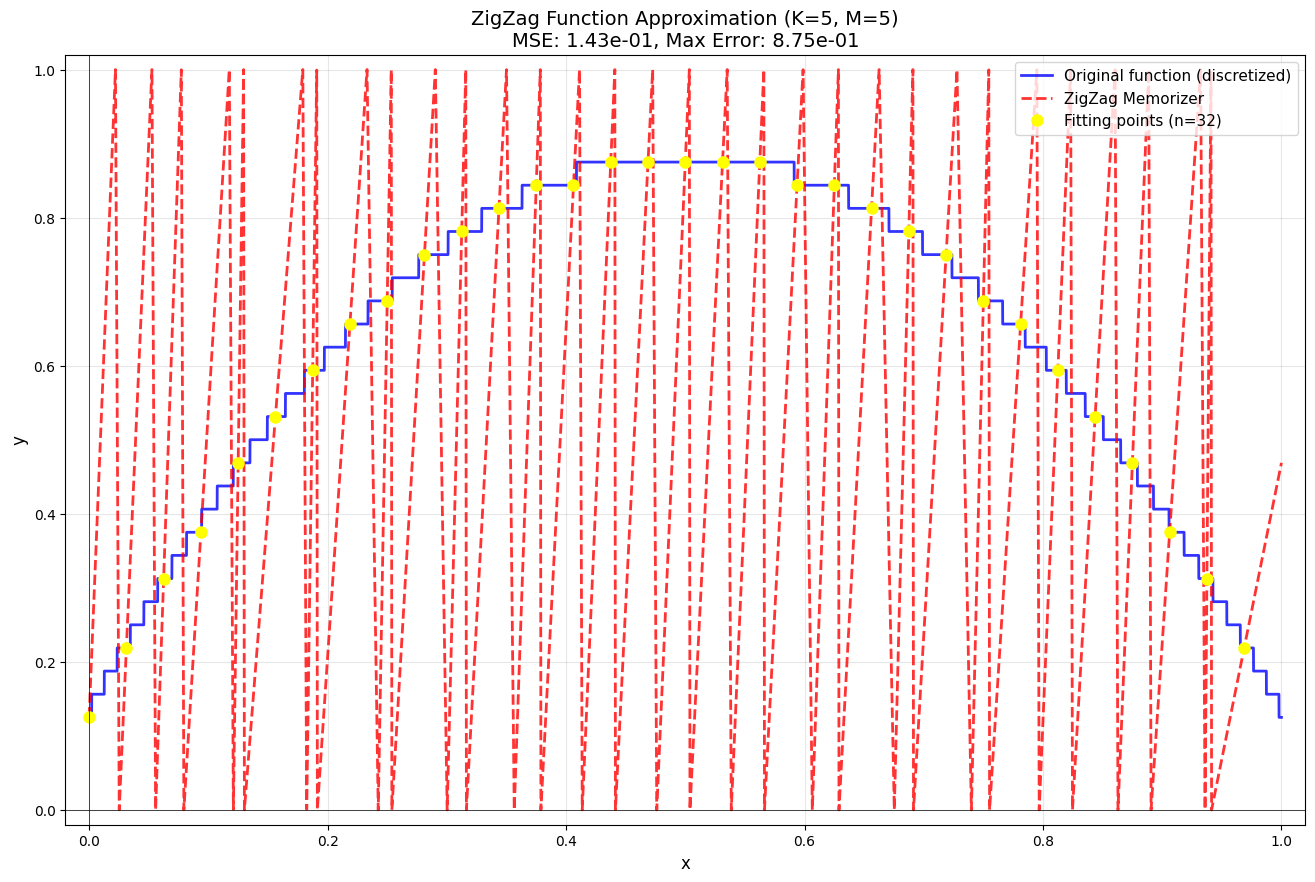

In [6]:
# Define parameter list for zig-zag memorizer demonstrations
zigzag_param_list = [(2, 2), (3, 3), (4, 4), (5, 5)]

# Demonstrate zig-zag memorizer with base function comparison for multiple parameters
zig_zag_memorizer = ZigZagMemorizer(base_function, K=2, M=2, dtype=dtype, device=device)
zig_zag_memorizer.plot_with_base_function_for_parameter_list(zigzag_param_list)

# Optional: Plot only the memorizers without base function (uncomment to use)
# Uncomment the line below to see only the zig-zag memorizer shapes for each parameter combination
# zig_zag_memorizer.plot_for_parameter_list(zigzag_param_list)

### Zig-Zag Coding Scheme Evaluation

Now we evaluate the complete coding scheme with the zig-zag memorizer. Note that in 1D, the entire coding scheme is given by the encoder composed with the memorizer function, as the decoder is just the identity. The approximation gets more accurate as $K$ and $M$ are increased, though runtime grows exponentially with $K$.

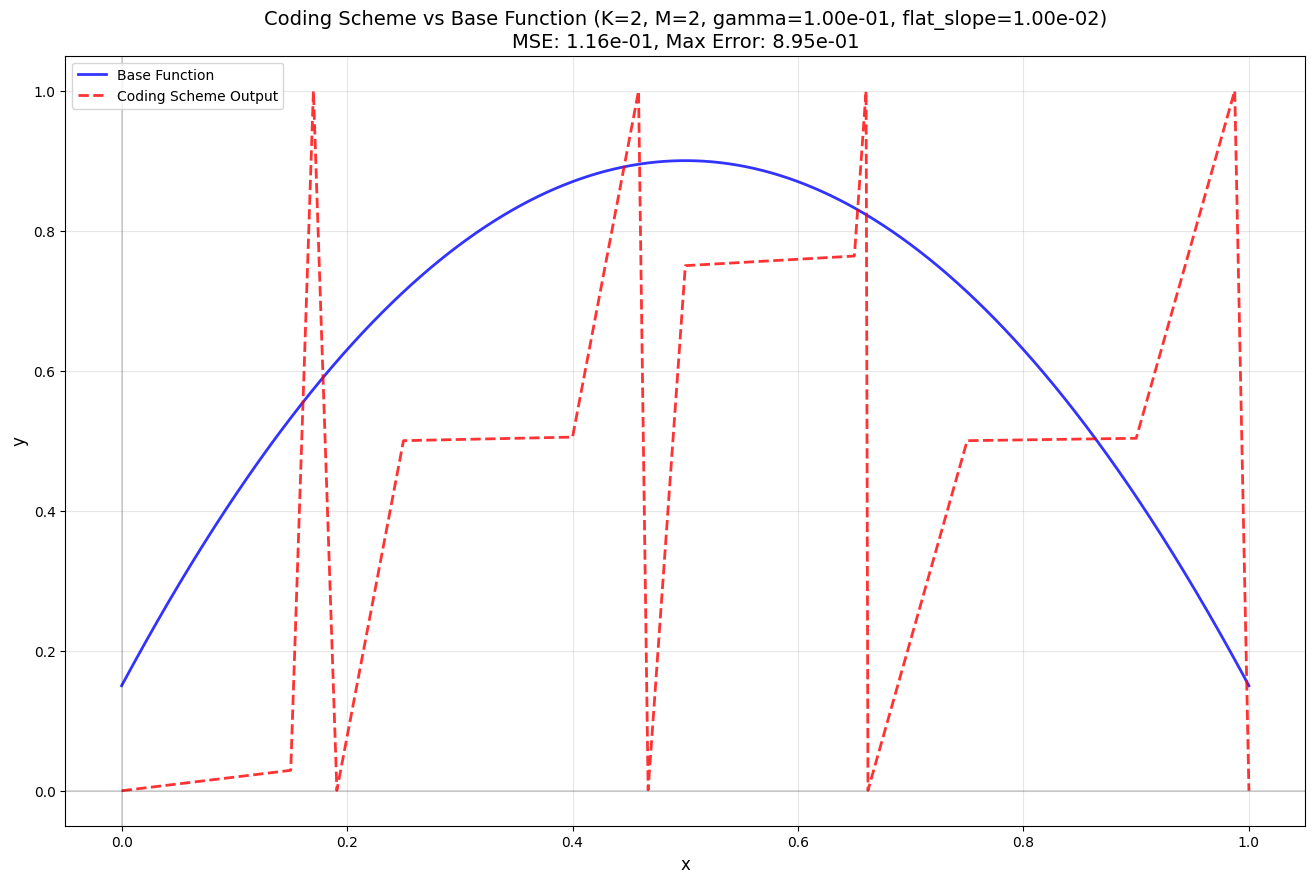

For Squared Shifted Function with Zig-Zag with parameters K=2, M=2, gamma=1.00e-01, flat_slope=1.00e-02:
 - L2 error: 3.41e-01, Max error: 8.95e-01


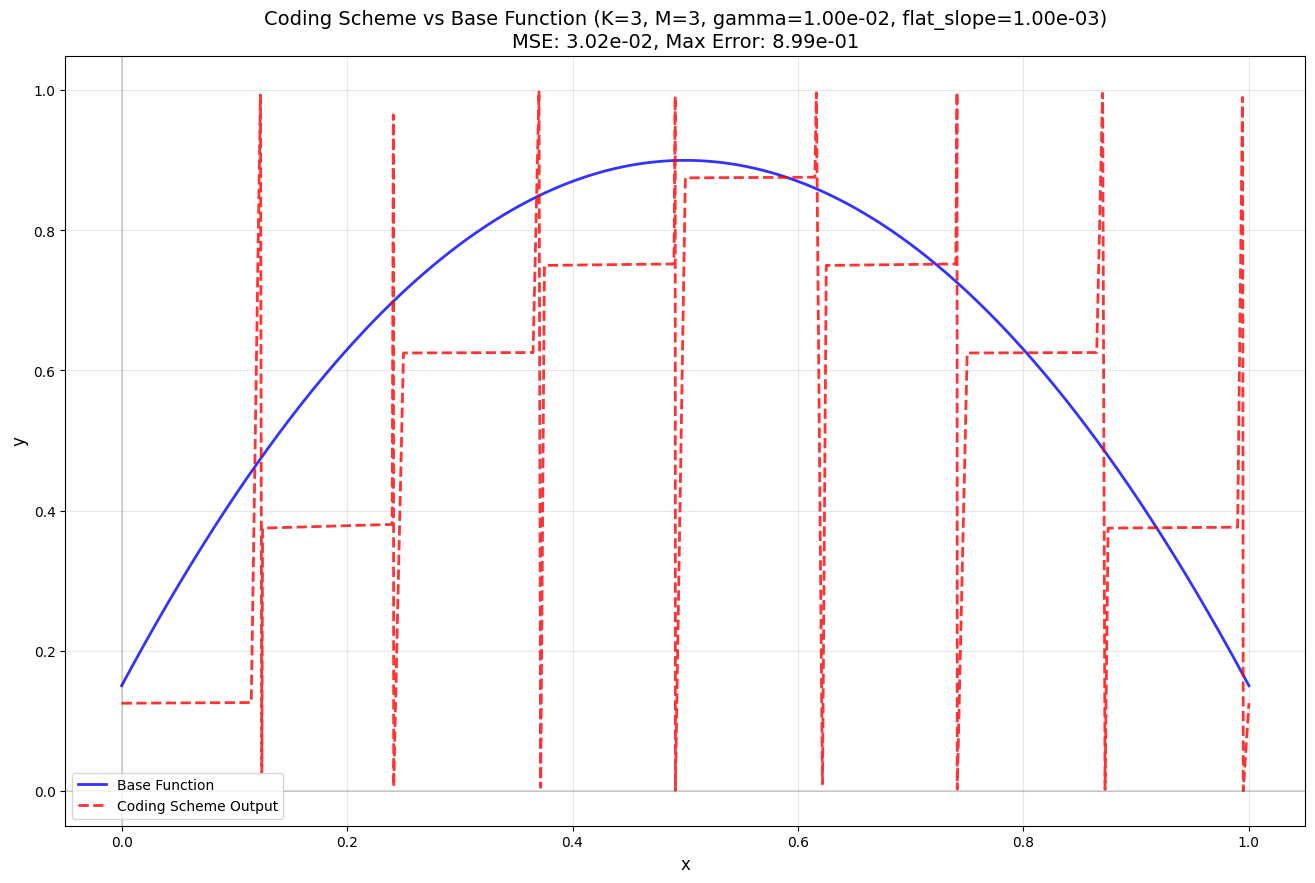

For Squared Shifted Function with Zig-Zag with parameters K=3, M=3, gamma=1.00e-02, flat_slope=1.00e-03:
 - L2 error: 1.74e-01, Max error: 8.99e-01


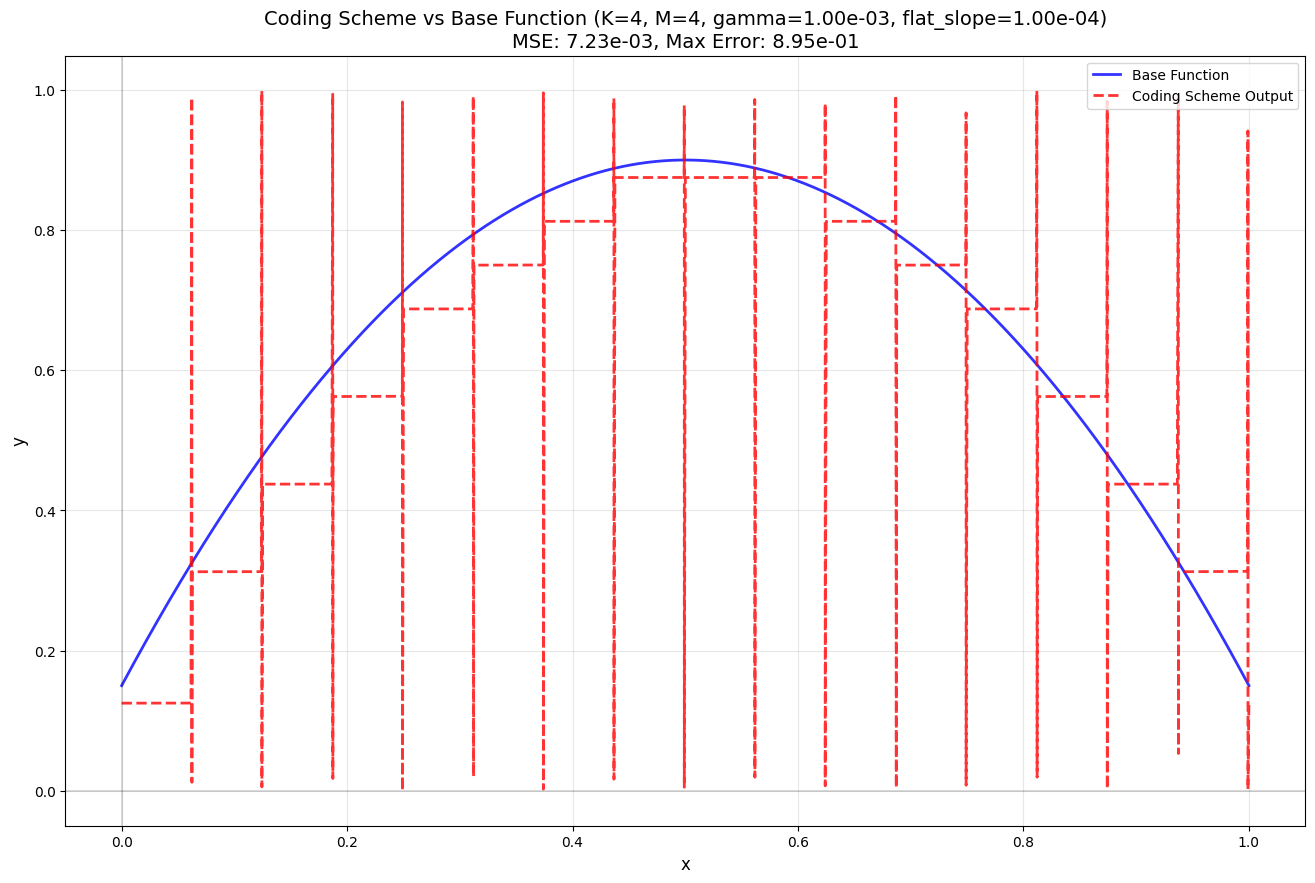

For Squared Shifted Function with Zig-Zag with parameters K=4, M=4, gamma=1.00e-03, flat_slope=1.00e-04:
 - L2 error: 8.57e-02, Max error: 8.77e-01


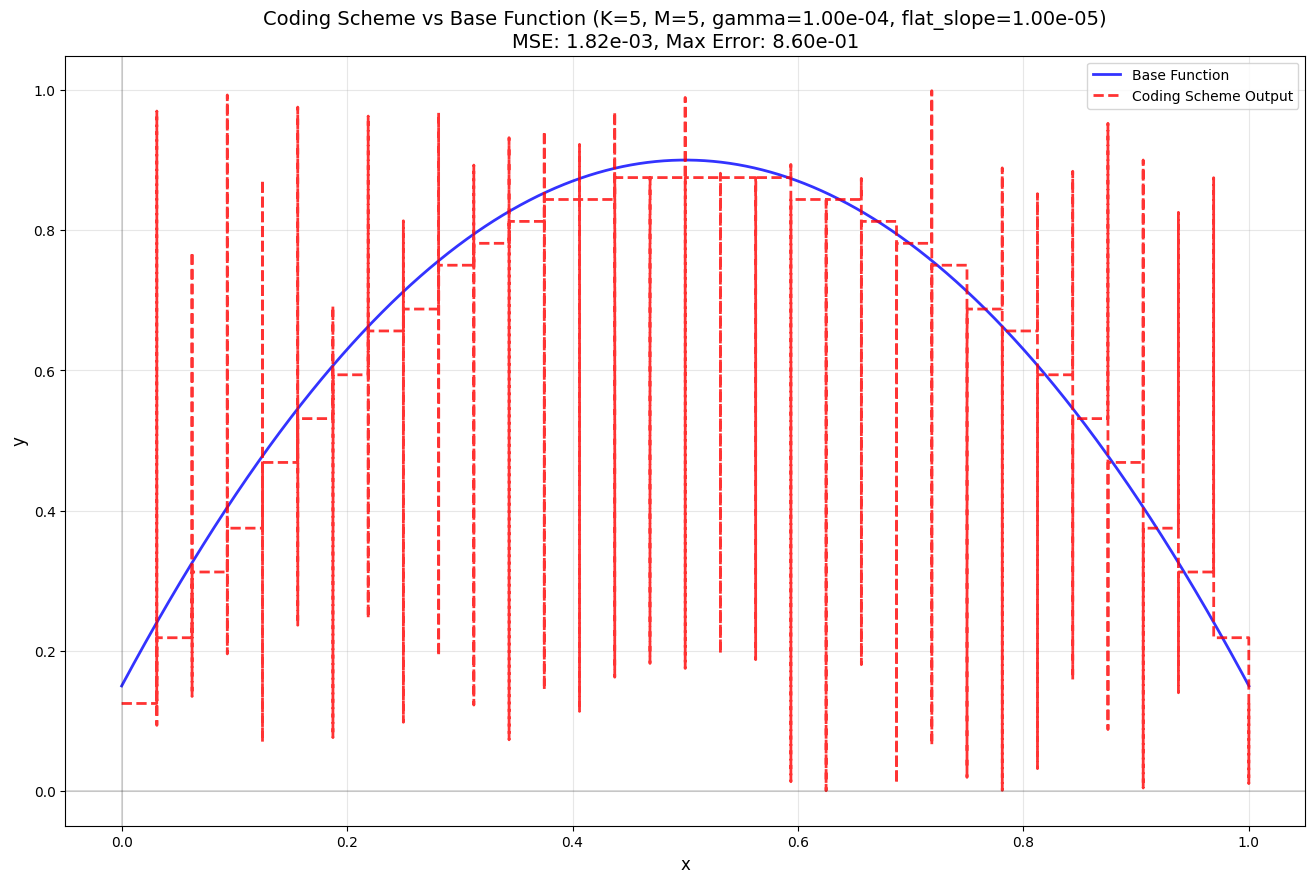

For Squared Shifted Function with Zig-Zag with parameters K=5, M=5, gamma=1.00e-04, flat_slope=1.00e-05:
 - L2 error: 4.22e-02, Max error: 6.27e-01


[(2, 2, 0.1, 0.01, 0.34112066461424356, 0.8954411108678135),
 (3, 3, 0.01, 0.001, 0.1738543026354324, 0.8990526947969867),
 (4, 4, 0.001, 0.0001, 0.08569545925012695, 0.8772830085476216),
 (5, 5, 0.0001, 1e-05, 0.04217003497005524, 0.6270984863727729)]

In [ ]:
# Create and evaluate coding scheme with zig-zag memorizer
coding_scheme_zigzag = CodingScheme1D(base_function, memorizer_type="zig-zag", dtype=dtype, device=device)

# Evaluate for multiple parameter combinations (errors are displayed in plots)
zigzag_coding_params = [(2,2,0.1,1e-2), (3,3,0.01,1e-3), (4,4,0.001,1e-4), (5,5,0.0001,1e-5)]
_ = coding_scheme_zigzag.evaluate_for_list_of_parameters(zigzag_coding_params, f"{base_function_name} with Zig-Zag", plot=True)

## Part 3: Coding Scheme with PLCSM Memorizer

The PLCSM (Piecewise Linear Continuous Slope Matching) memorizer provides smoother approximations by ensuring continuous derivatives at junction points.

**🔑 Key Insight - Network Width:**
- **PLCSM Memorizer = Width-2 FNN**: Unlike the zig-zag construction, PLCSM requires width-2
- **Coding Scheme with PLCSM = Width-2**: The complete coding scheme is now width-2
- **⚠️ Important Comparison**: While PLCSM approximations often look visually better than zig-zag, they use **double the network width**! This is a comparatively very unfair advantage - achieving good approximations with width-1 is **terrifically harder**. The zig-zag results are therefore much more impressive from a minimal-width perspective.
- **Still built from scratch**: Even PLCSM uses only our $\sigma_{a,b}^{c,d}$ width-1 LReLU compositions as building blocks

When comparing results, remember that width-2 has significantly more representational power than width-1.

**Parameter Control:**
- **$K$, $M$**: Control discretization and fitting precision (same as zig-zag)
- **flat_slope**: Additional smoothness parameter for PLCSM (should converge to 0)
- **⚠️ Warning**: Large $K$ and $M$ values cause exponential runtime increase and numerical instabilities.

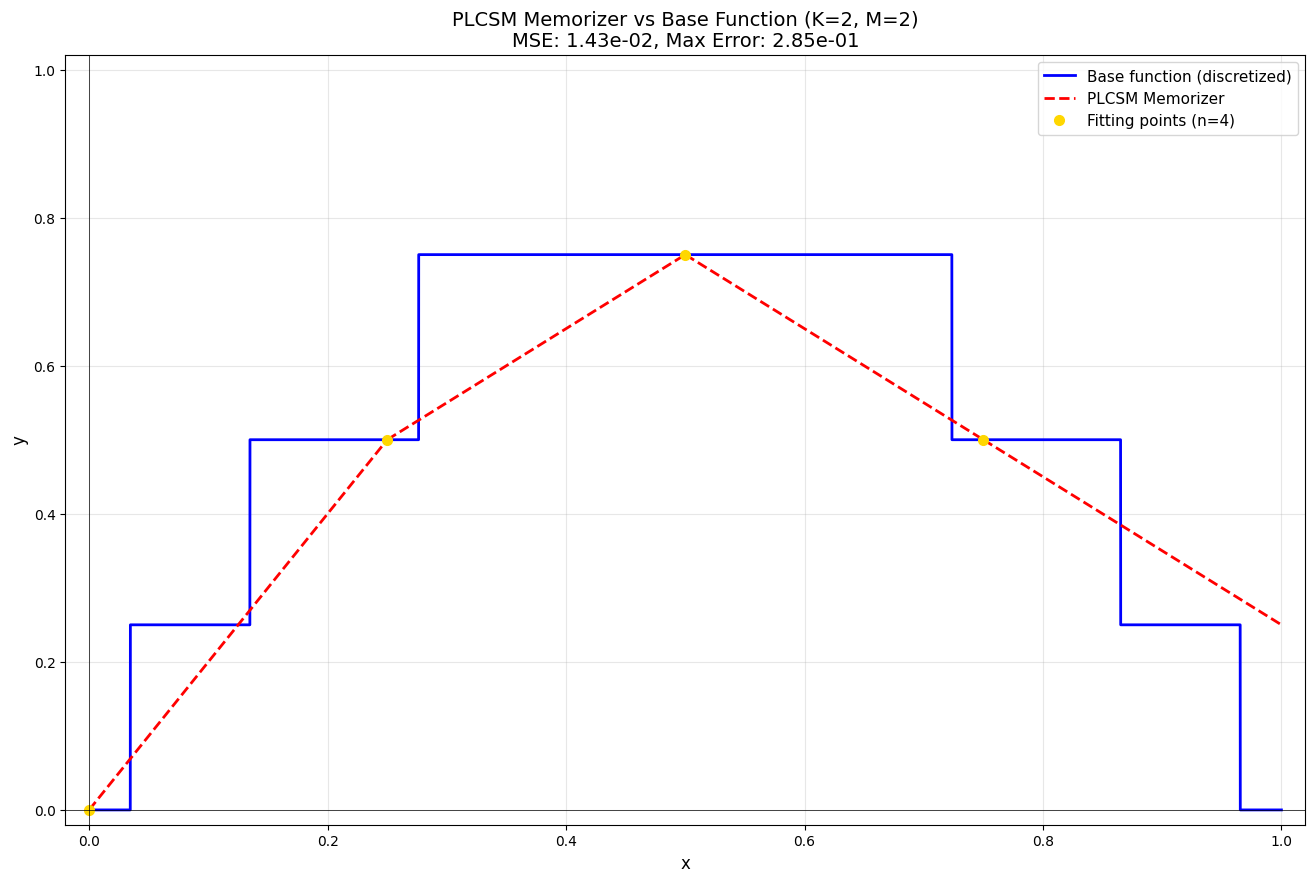

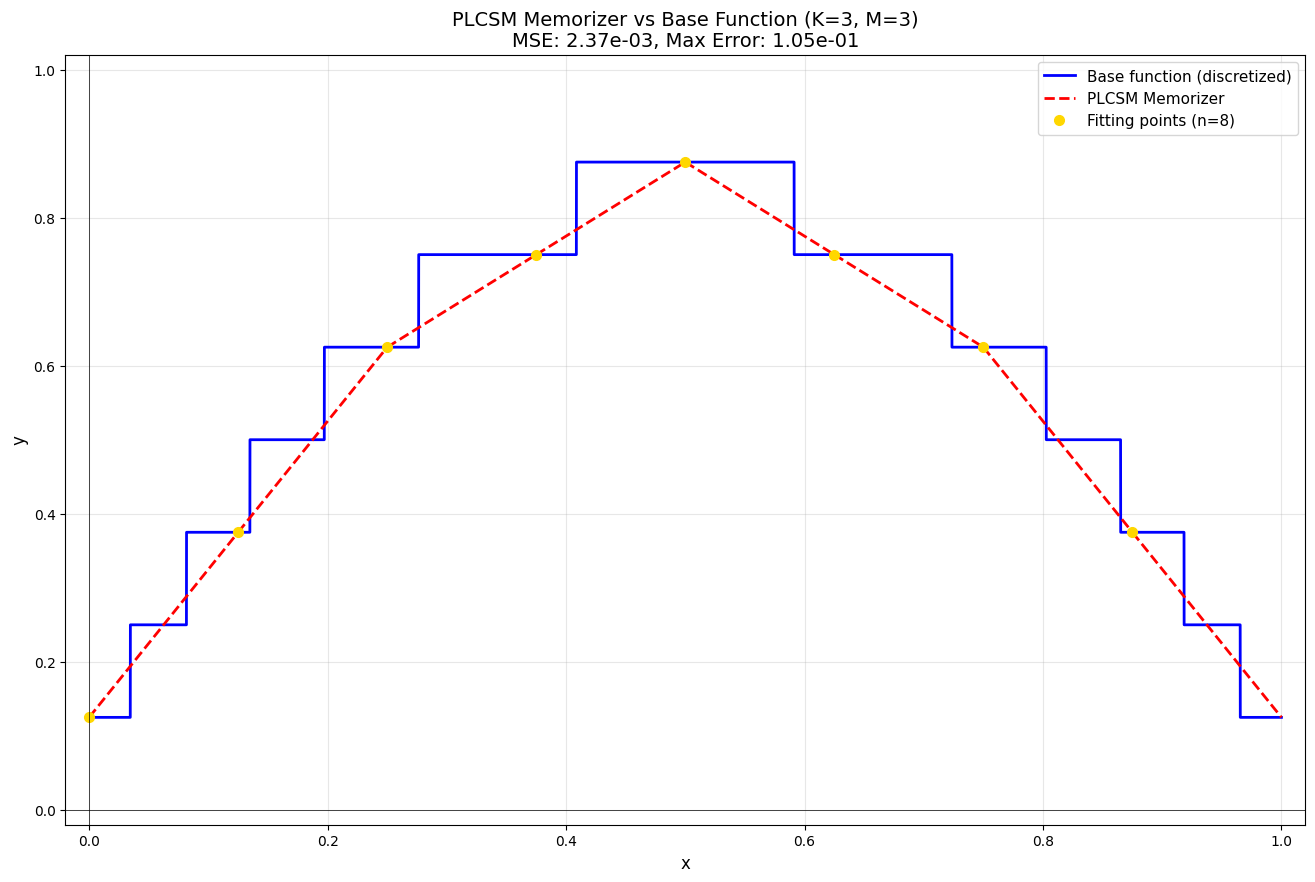

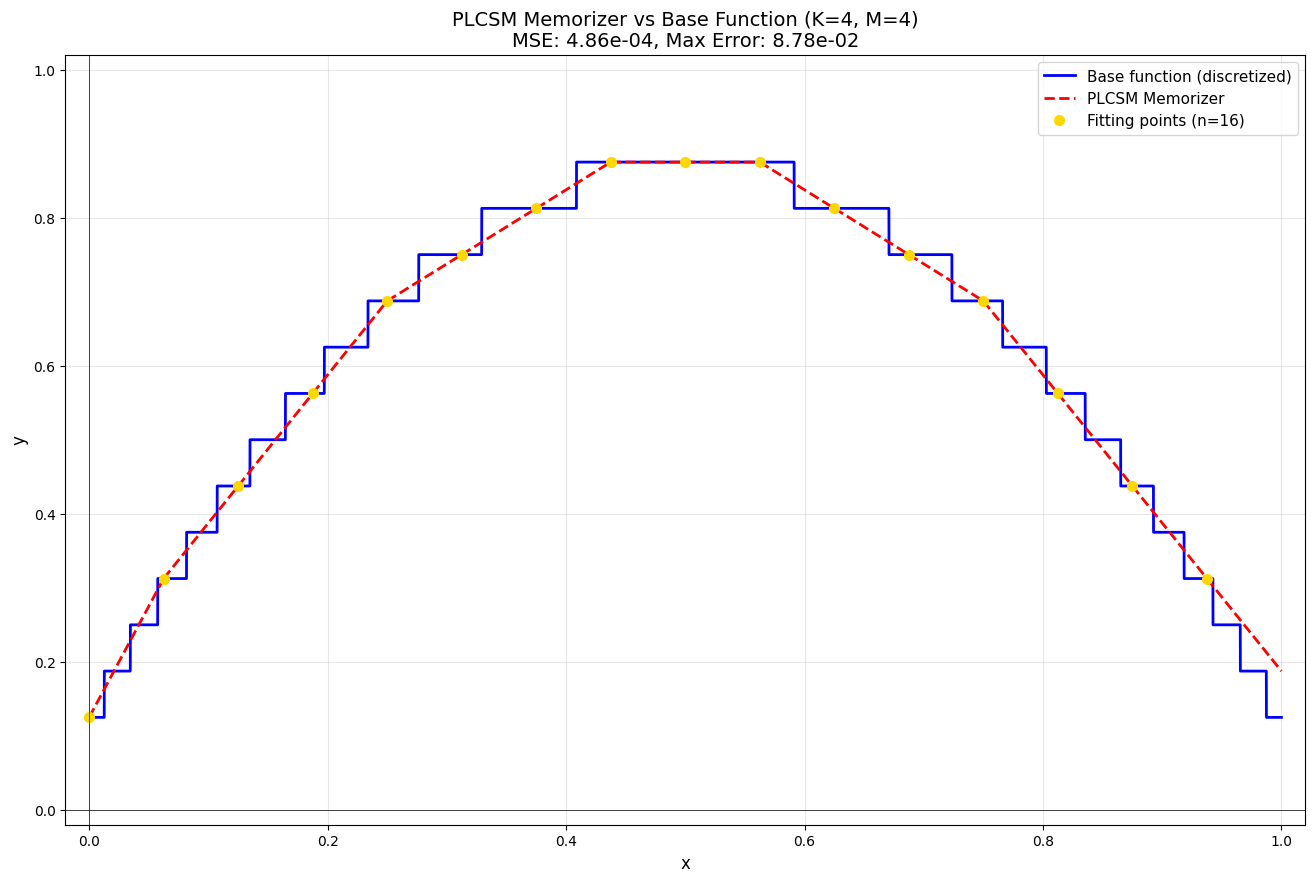

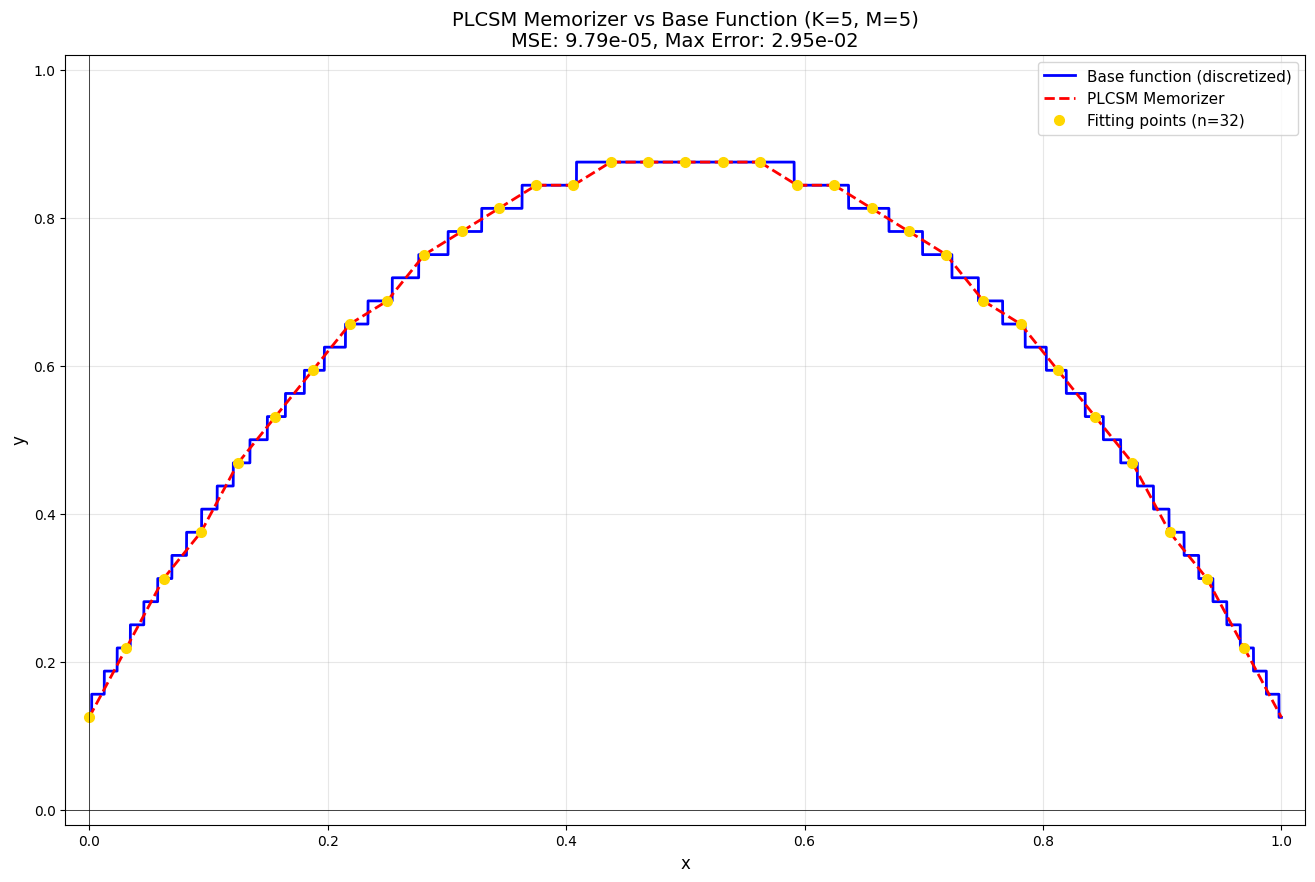

In [9]:
# Define parameter list for PLCSM memorizer demonstrations
# Each tuple is (K, M, flat_slope)
plcsm_param_list = [(2, 2, 1e-2), (3, 3, 1e-3), (4, 4, 1e-4), (5, 5, 1e-5)]

# Demonstrate PLCSM memorizer with base function comparison for multiple parameters
plcsm_memorizer = PLCSMMemorizer(base_function, K=2, M=2, flat_slope=1e-2, dtype=dtype, device=device)
plcsm_memorizer.plot_with_base_function_for_parameter_list(plcsm_param_list)

# Optional: Plot only the memorizers without base function (uncomment to use)
# Uncomment the line below to see only the PLCSM memorizer shapes for each parameter combination
# plcsm_memorizer.plot_for_parameter_list(plcsm_param_list)

### PLCSM Coding Scheme Evaluation

Now we evaluate the complete coding scheme with the PLCSM memorizer. The approximation improves as flat_slope and $\gamma$ are decreased, or if $K$ and $M$ are increased. However, note that $\gamma$ or flat_slope smaller than $10^{-6}$ leads to numerical instabilities. The coding scheme can approximate the encoder arbitrarily well with respect to the supremum norm outside of a subset that we can make arbitrarily small, which suffices for $L^p$ approximation.

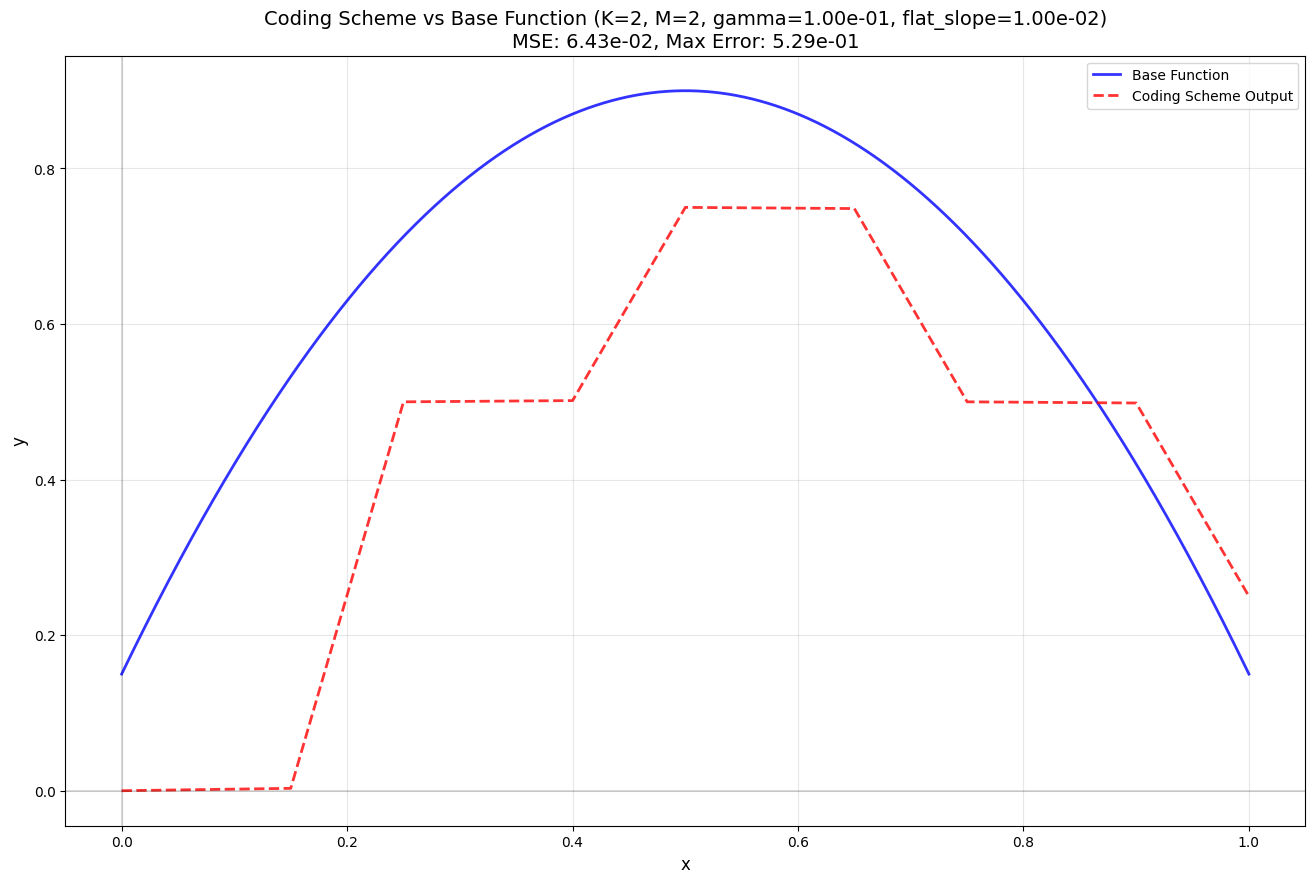

For Squared Shifted Function with PLCSM with parameters K=2, M=2, gamma=1.00e-01, flat_slope=1.00e-02:
 - L2 error: 2.54e-01, Max error: 5.29e-01


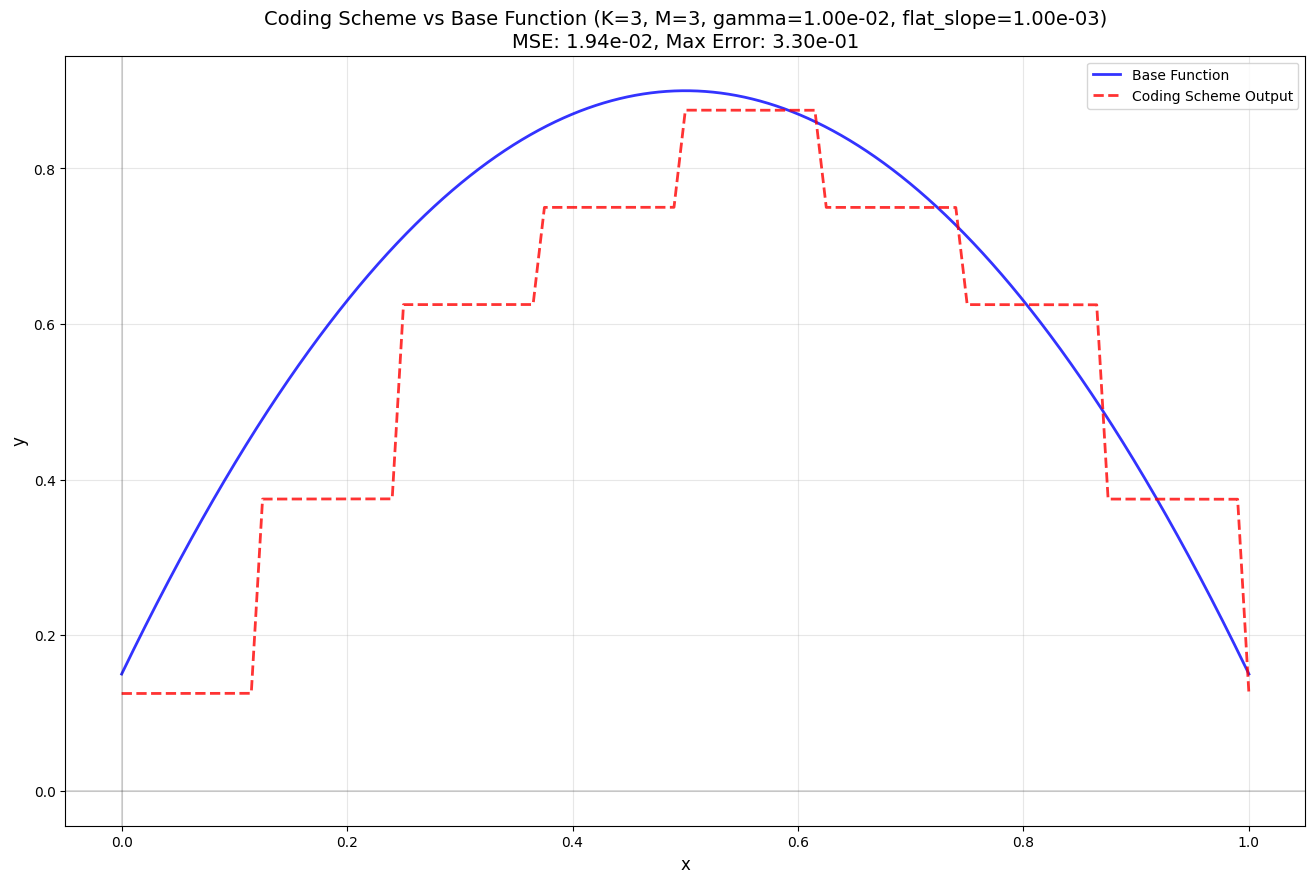

For Squared Shifted Function with PLCSM with parameters K=3, M=3, gamma=1.00e-02, flat_slope=1.00e-03:
 - L2 error: 1.39e-01, Max error: 3.30e-01


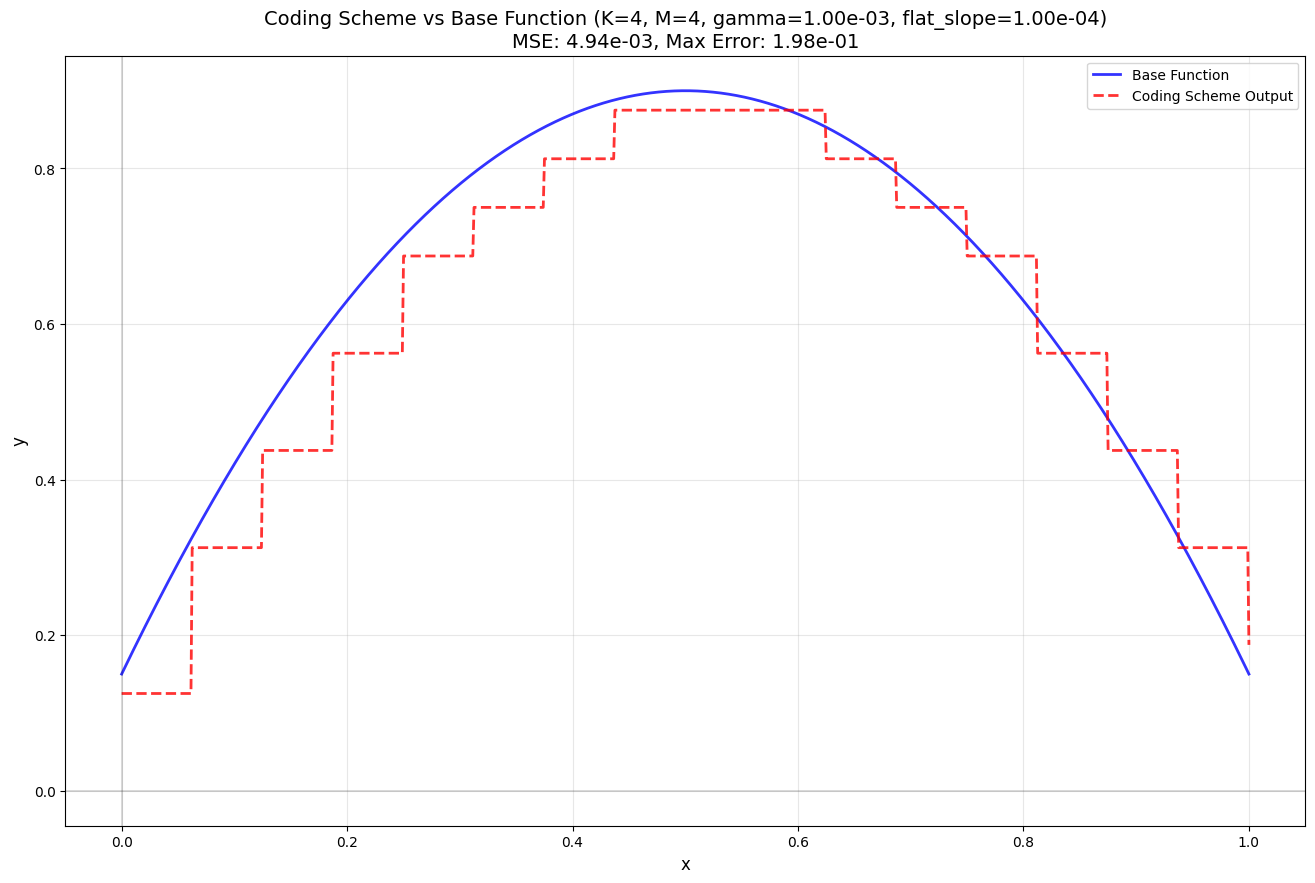

For Squared Shifted Function with PLCSM with parameters K=4, M=4, gamma=1.00e-03, flat_slope=1.00e-04:
 - L2 error: 7.03e-02, Max error: 1.98e-01


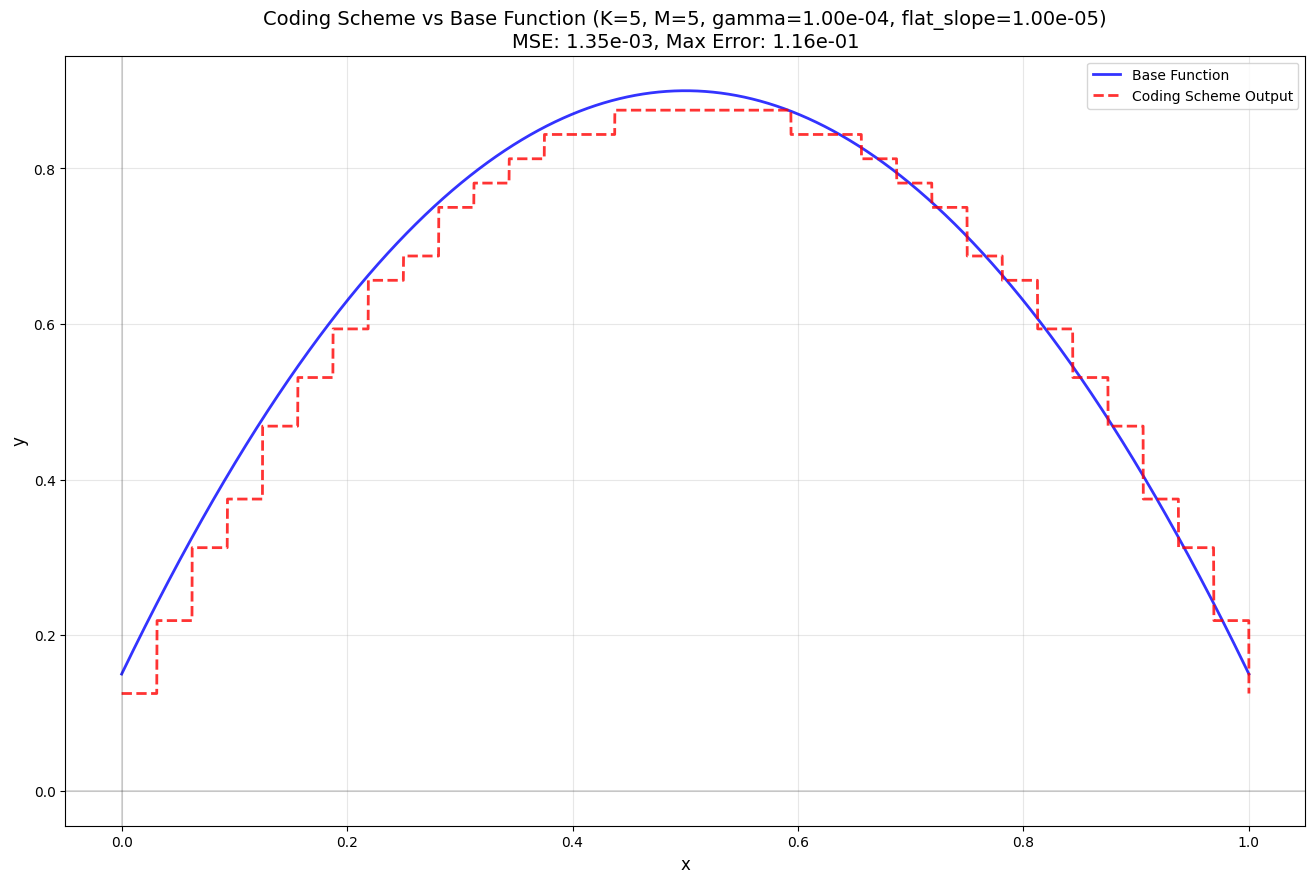

For Squared Shifted Function with PLCSM with parameters K=5, M=5, gamma=1.00e-04, flat_slope=1.00e-05:
 - L2 error: 3.67e-02, Max error: 1.15e-01


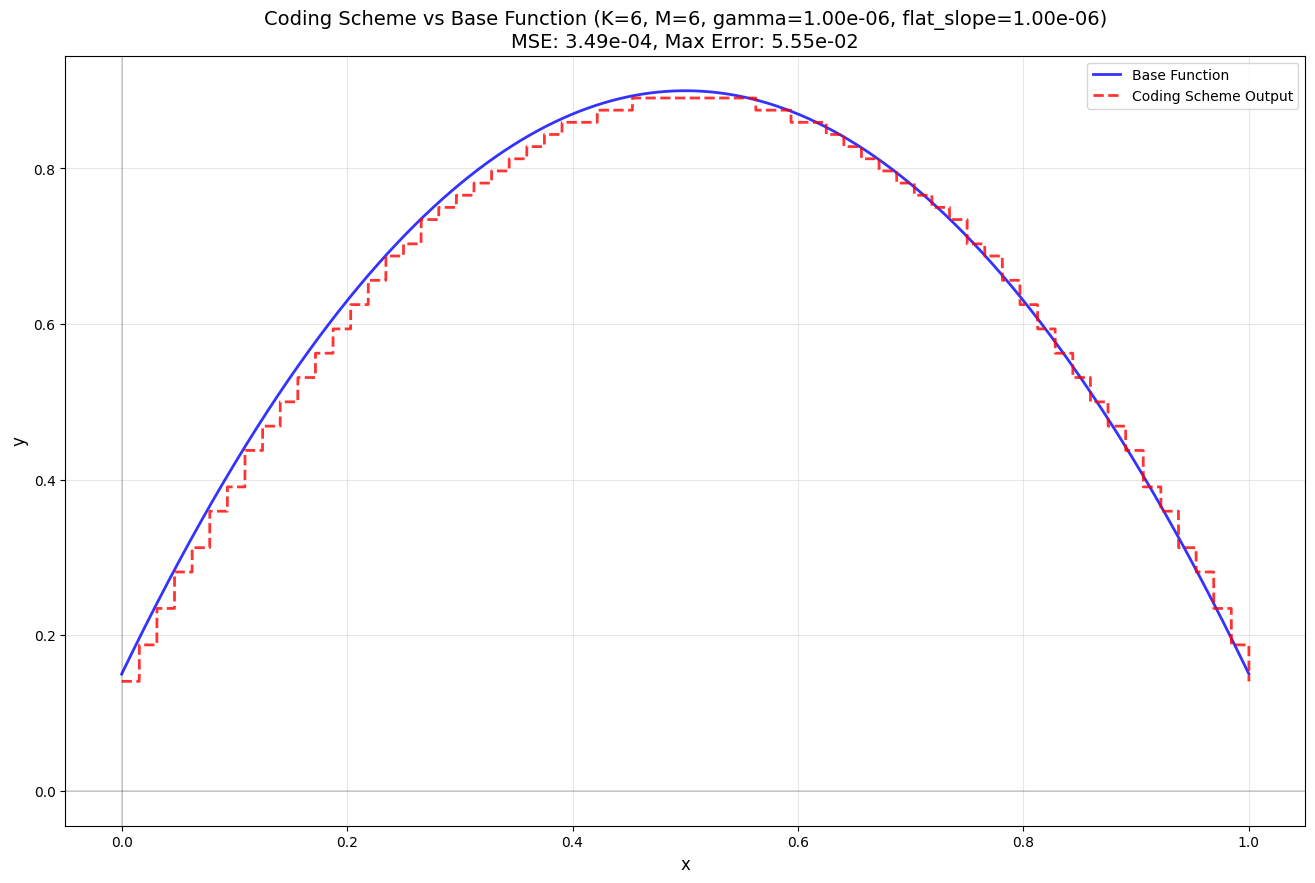

For Squared Shifted Function with PLCSM with parameters K=6, M=6, gamma=1.00e-06, flat_slope=1.00e-06:
 - L2 error: 1.87e-02, Max error: 5.54e-02


[(2, 2, 0.1, 0.01, 0.2535923078345303, 0.5294569450194342),
 (3, 3, 0.01, 0.001, 0.13937477442738552, 0.32989069807070737),
 (4, 4, 0.001, 0.0001, 0.07025783394773866, 0.19788785768465722),
 (5, 5, 0.0001, 1e-05, 0.036692660459950475, 0.11540618742672692),
 (6, 6, 1e-06, 1e-06, 0.018692755275278215, 0.05544940762545836)]

In [ ]:
# Create and evaluate coding scheme with PLCSM memorizer
coding_scheme_plcsm = CodingScheme1D(base_function, memorizer_type="plcsm", dtype=dtype, device=device)

# Evaluate for multiple parameter combinations (errors are displayed in plots)
plcsm_coding_params = [(2,2,0.1,1e-2), (3,3,0.01,1e-3), (4,4,0.001,1e-4), (5,5,0.0001,1e-5), (6,6,1e-6,1e-6)]
_ = coding_scheme_plcsm.evaluate_for_list_of_parameters(plcsm_coding_params, f"{base_function_name} with PLCSM", plot=True)